Imports
===

In [12]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import time
import math
from sklearn.preprocessing import MinMaxScaler

Prepare Dataset
===

In [13]:
#Load data from csv and drop NaN
dataset = pd.read_csv('MSFT.csv')
dataset = dataset.dropna()

#only use close price for the prediction of the next price
dataset = dataset.iloc[:,4:5].values

#normalize data
sc = MinMaxScaler(feature_range = (0, 1))
dataset = sc.fit_transform(dataset)

#split into train and test, firts 80% for train, last 20% for test
train_size = int(len(dataset) * 0.8)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

#convert to tensor for batch processing
train_tensor = torch.FloatTensor(train)
test_tensor = torch.FloatTensor(test)

print('Shape de Train Tensor',train_tensor.shape)
print('Shape de Test Tensor',test_tensor.shape)

Shape de Train Tensor torch.Size([7266, 1])
Shape de Test Tensor torch.Size([1817, 1])


In [14]:

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

#RNN model
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        #numero de capas ocultas
        self.hidden_size = hidden_size

        #define the recurrent layer, we have two options: 
        #self.in2hidden = nn.Linear(input_size + hidden_size, hidden_size, bias=True)   #using a linear layer where the input is the concatenation of the input and hidden state to produce h_t= f(Wx_t + b + Uh_t-1 + b)
        self.in2hidden = nn.RNN(input_size, hidden_size)    #builtin rnn of pytorch
        
        self.in2output = nn.Linear(hidden_size, output_size)
    
    def forward(self, x, hidden_state):
        #-----Use this if you are using a linear layer for the recurrent layer----
        #combined = torch.cat((x, hidden_state), 1)
        #hidden = torch.sigmoid(self.in2hidden(combined))
        #output = self.in2output(hidden)

        #-----Use this if you are using a RNN layer for the recurrent layer----
        output, hidden = self.in2hidden(x, hidden_state)
        # Reshaping the outputs such that it can be fit into the fully connected layer
        output = output.contiguous().view(-1, self.hidden_size)
        output = self.in2output(output)
        
        return output, hidden
    

    def init_hidden(self):
        '''
            This is used to initialize the hidden state with zeros when we start training
        '''
        #return nn.init.kaiming_uniform_(torch.empty(1, self.hidden_size))
        return torch.zeros(1, self.hidden_size)
    
#trainig por epoca recorriendo todos los batch
def train(input_tensor, criterion, optimizer,model,k,predict):
    hidden = model.init_hidden()    #al inicio de cada epoca se inicializa el hidden state en 0
    
    optimizer.zero_grad()
    loss = 0
    if predict==False:
        for value in range(input_tensor.size(0)-1):   #for each value in batch
            target_tensor= input_tensor[value+1]
            output, hidden = model(input_tensor[value].unsqueeze(0) , hidden) 
            
            loss += criterion(output, target_tensor.unsqueeze(0))
            #step to truncate backpropagation in time to save memory
            if (value +1)%k==0:
                loss_para_return=loss.item() / k #average loss
                
                loss.backward()
                optimizer.step()  #optimizer step performed after k values passed trough the forward
                optimizer.zero_grad()
                hidden = hidden.detach()
                loss = 0
    else:
        lista_output=[]
        for currentIterador in range (input_tensor.size(0)-k):  #(0,7000)
            for value in range(currentIterador,currentIterador+k):#(1,201)
                output, hidden = model(input_tensor[value].unsqueeze(0) , hidden) 
            output_para_return=output.detach().numpy()
            lista_output.append(output_para_return)
            hidden_para_return=hidden
            loss_para_return=0
            print("currentIterador: ",currentIterador, end="\r")
        output=lista_output
        loss_para_return=0

        
    return output, loss_para_return



#training
def trainEpoch(input_tensor, epochs, criterion, optimizer,model,k,predict=False):
    start = time.time()
    print_every = 1
    plot_every = 1
    all_losses = []
    total_loss = 0 # Reset every plot_every iters
    
    for epoch in range(1, epochs + 1):
        output, loss = train(input_tensor, criterion, optimizer,model,k,predict)
        total_loss += loss
        if epoch % print_every == 0:
            print('%s (%d %d%%) %.7f' % (timeSince(start), epoch, epoch / epochs * 100, loss))
        if epoch % plot_every == 0:
            all_losses.append(total_loss / plot_every)
            total_loss = 0
    return all_losses

In [15]:
#training
epochs = 100
hidden_size = 10
lr=0.01

# Define input and target tensors
input_tensor = train_tensor

input_size = 1
output_size = 1

# Define Model
torch.manual_seed(5)
model= RNN(input_size, hidden_size, output_size)

# Define Loss, Optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
k=250 # truncation length. 
all_losses = trainEpoch(input_tensor, epochs, criterion, optimizer,model,k,predict=False)


0m 3s (1 1%) 0.0066047
0m 7s (2 2%) 0.0016514
0m 10s (3 3%) 0.0044450
0m 14s (4 4%) 0.0033713
0m 17s (5 5%) 0.0002841
0m 21s (6 6%) 0.0001245
0m 25s (7 7%) 0.0005259
0m 28s (8 8%) 0.0001449
0m 32s (9 9%) 0.0001155
0m 35s (10 10%) 0.0002706
0m 39s (11 11%) 0.0001123
0m 43s (12 12%) 0.0001045
0m 46s (13 13%) 0.0001261
0m 50s (14 14%) 0.0001435
0m 53s (15 15%) 0.0001061
0m 57s (16 16%) 0.0001539
1m 0s (17 17%) 0.0000935
1m 4s (18 18%) 0.0000846
1m 8s (19 19%) 0.0000940
1m 11s (20 20%) 0.0000779
1m 15s (21 21%) 0.0000682
1m 18s (22 22%) 0.0000595
1m 22s (23 23%) 0.0000585
1m 25s (24 24%) 0.0000648
1m 29s (25 25%) 0.0000673
1m 33s (26 26%) 0.0000665
1m 36s (27 27%) 0.0000569
1m 40s (28 28%) 0.0000422
1m 43s (29 28%) 0.0000290
1m 47s (30 30%) 0.0000202
1m 50s (31 31%) 0.0000168
1m 54s (32 32%) 0.0000181
1m 58s (33 33%) 0.0000230
2m 1s (34 34%) 0.0000302
2m 5s (35 35%) 0.0000388
2m 8s (36 36%) 0.0000482
2m 12s (37 37%) 0.0000578
2m 15s (38 38%) 0.0000673
2m 19s (39 39%) 0.0000763
2m 22s (40 4

[0.0066046533584594724, 0.001651422381401062, 0.004444956302642822, 0.0033712728023529053, 0.00028413978219032286, 0.00012447939813137055, 0.0005259477496147156, 0.0001448991149663925, 0.00011553780734539032, 0.00027064526081085205, 0.00011233838647603989, 0.00010449983179569244, 0.00012607428431510924, 0.00014346666634082795, 0.00010606078058481216, 0.00015390466153621674, 9.346131980419158e-05, 8.461103588342666e-05, 9.403486549854279e-05, 7.786639779806137e-05, 6.817297637462617e-05, 5.952315032482147e-05, 5.851778388023376e-05, 6.479340046644211e-05, 6.72885924577713e-05, 6.652427464723586e-05, 5.685904622077942e-05, 4.2227517813444135e-05, 2.9009800404310226e-05, 2.02078428119421e-05, 1.680018752813339e-05, 1.8125757575035094e-05, 2.2977668792009353e-05, 3.0184347182512283e-05, 3.881001099944115e-05, 4.8174165189266207e-05, 5.7790517807006834e-05, 6.728868186473847e-05, 7.633717358112335e-05, 8.456619828939437e-05, 9.148083627223969e-05, 9.637638181447983e-05, 9.823884814977646e-0

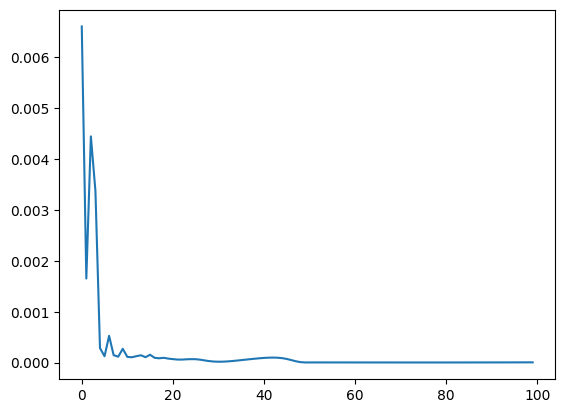

In [16]:
print(all_losses)

# Plot the losses
import matplotlib.pyplot as plt
plt.figure()
plt.plot(all_losses)
plt.show()


In [17]:
#plot de valores reales vs valores predichos
# Define input and target tensors


#prediccion de valores usando el modelo ya entrenado
# Define input and target tensors
input_tensor = train_tensor
output, loss = train(input_tensor, criterion, optimizer,model,k,predict=True)
output=np.array(output)
output=output.reshape(-1,1)


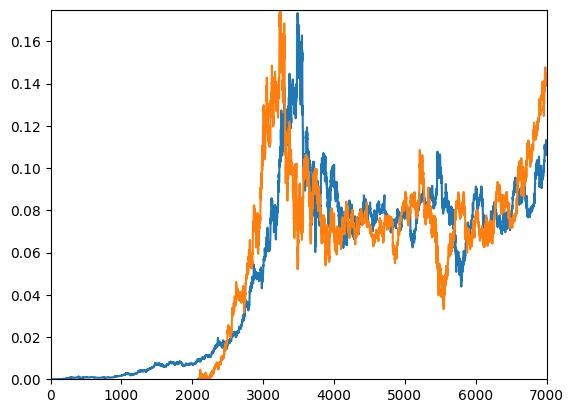

In [18]:

#plot de valores reales vs valores predichos
# Define input and target tensors
plt.plot(train_tensor)
plt.plot(output)
#plt.plot(output*4-0.4135)
plt.axis([0, 7000, 0, 0.175])
#plt.axis([4000, 4020, 0.08, 0.12])
plt.show()

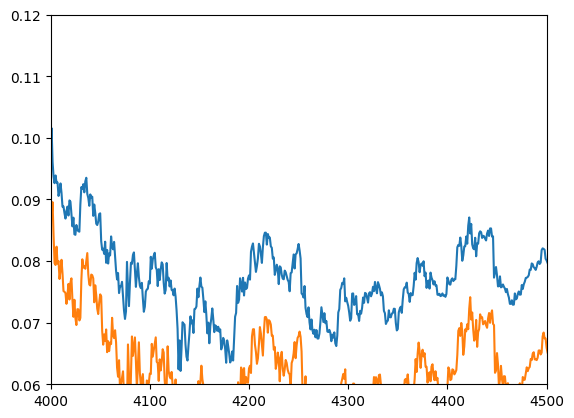

In [19]:
#agregarle 500 ceros al inicio de output
output_2=np.concatenate((np.zeros((k,1)),output), axis=0)
plt.plot(train_tensor)
plt.axis([4000, 4500, 0.06, 0.12])
plt.plot(output_2-0.01)

Testing phase
===

In [20]:

output_test, loss = train(test_tensor, criterion, optimizer,model,k,predict=True)
output_test=np.array(output_test)
output_test=output_test.reshape(-1,1)

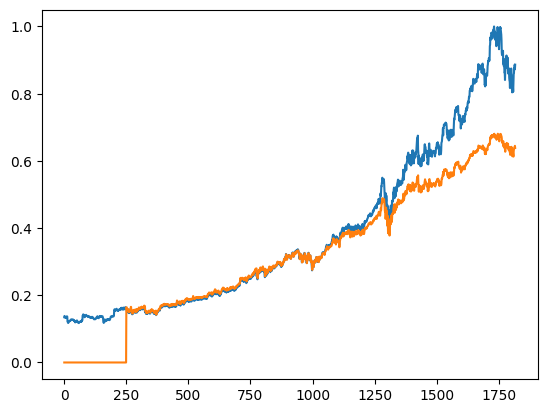

In [21]:
output_test_2=np.concatenate((np.zeros((250,1)),output_test), axis=0)
plt.plot(test_tensor)
plt.plot(output_test_2)
plt.show()

input tensor solo con pocos valores
====

In [22]:
exampleToPredict= input_tensor[0:4000]
output_example, loss = train(exampleToPredict, criterion, optimizer,model,k,predict=True)
output_example=np.array(output_example)
output_example=output_example.reshape(-1,1)


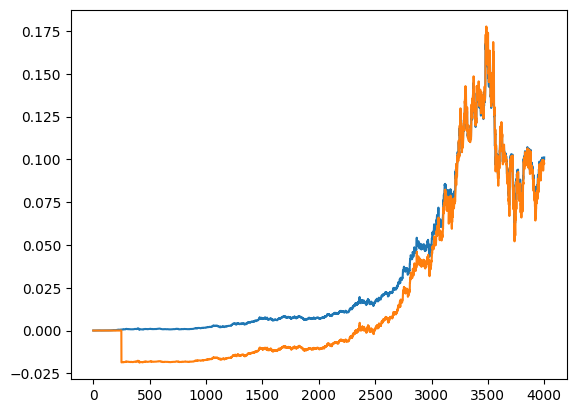

In [23]:
output_example_2=np.concatenate((np.zeros((k,1)),output_example), axis=0)
plt.plot(exampleToPredict)
plt.plot(output_example_2)
plt.show()